## Exploratory Data Analysis

### Importing libraries

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

### Reading Data

In [63]:
books = pd.read_csv("Books.csv", sep=";")
users = pd.read_csv("Users.csv", sep=";")
ratings = pd.read_csv("Ratings.csv", sep=";")

/home/aaryapatel/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [64]:
# Viewing the first few points of the books dataset, and its original shape
display(books.head())
books.shape

,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


(271379, 5)

In [65]:
# Viewing the first few points of the users dataset, and its original shape
display(users.head())
users.shape

,User-ID,Age
0,1,NaN
1,2,18
2,3,NaN
3,4,17
4,5,NaN


(278859, 2)

In [66]:
# Viewing the first few points of the ratings dataset, and its original shape
display(ratings.head())
ratings.shape

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


(1149780, 3)

### Cleaning data

In [67]:
# Rename 'User-ID' to 'UserID'
users = users.rename(columns={'User-ID': 'UserID'})

In [68]:
# Convert 'Ages' to numeric
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')

# Calculate the mean, median, and standard deviation 
print("Mean Age: ", users['Age'].mean())
print("Median Age: ", users['Age'].median())
print("Standard Deviation of Age: ", users['Age'].std())

Mean Age:  34.72840724853575
Median Age:  32.0
Standard Deviation of Age:  14.408645139788613


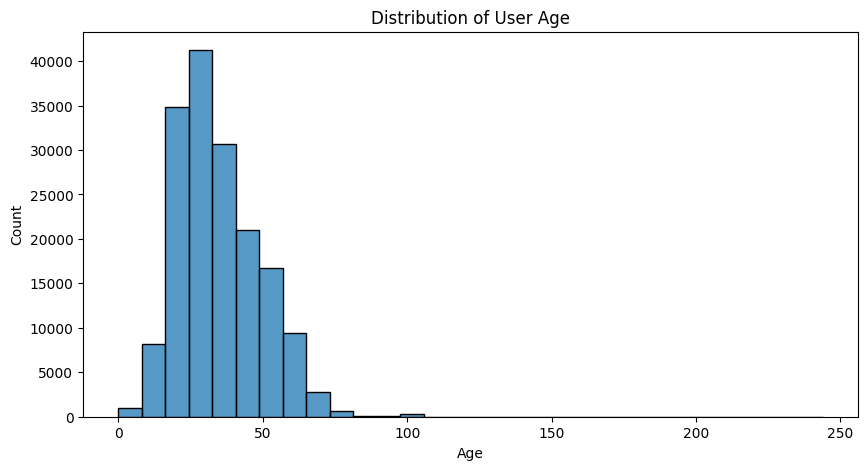

In [69]:
# Plot a histogram of 'Ages' to help understand the distribution of ages and find a logical age range 
plt.figure(figsize=(10,5))
sns.histplot(users['Age'], bins=30)
plt.title('Distribution of User Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Looking at the plot, a reasonable range should be from 5 to 85

In [70]:
# Clean 'Age' by removing and replacing NaN values and outliers such as < 5 and > 85 with the mean age
users.loc[(users.Age > 85) | (users.Age < 5), 'Age'] = np.nan
users['Age'] = users['Age'].fillna(users['Age'].mean())

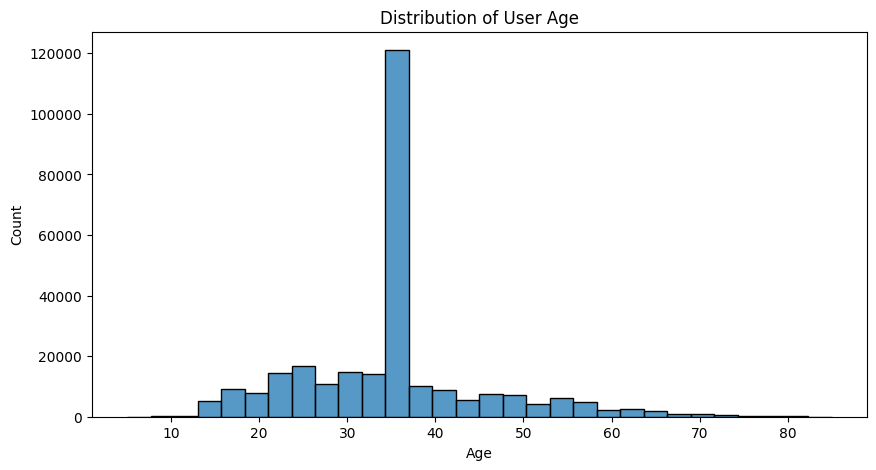

In [71]:
# Plot histogram of ages after cleaning values
plt.figure(figsize=(10,5))
sns.histplot(users['Age'], bins=30)
plt.title('Distribution of User Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [72]:
# Rename 'User-ID' to 'UserID'
ratings = ratings.rename(columns={'User-ID': 'UserID'})

In [73]:
display(ratings.head())
print(ratings.shape)

,UserID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


(1149780, 3)


In [74]:
# Filter 'ratings' dataset to only include rows where 'ISBN' is also found in the 'ISBN' in 'books' df
ratings = ratings[ratings.ISBN.isin(books.ISBN)]
print (ratings.shape)

(1031175, 3)


This will clean the dataset from any values which won't be of use for the recommendation system and speed up the algorithm by even the smallest bit.

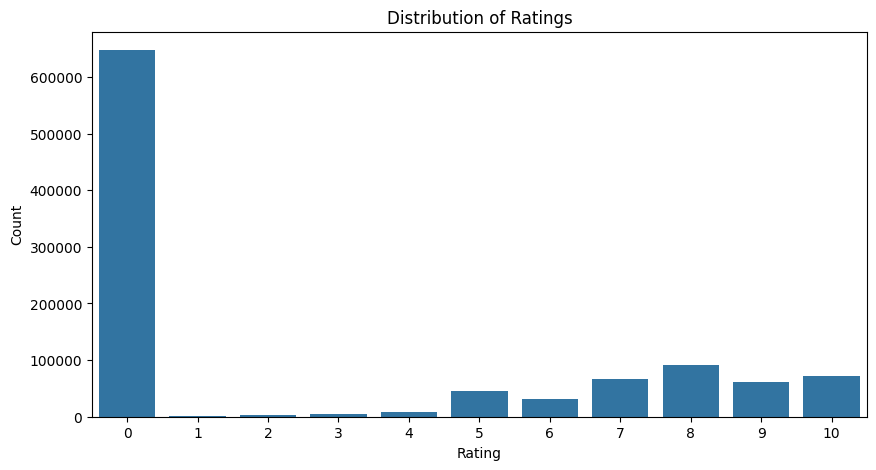

In [75]:
# Distribution of Ratings
plt.figure(figsize=(10,5))
sns.countplot(x='Rating', data=ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [76]:
# Calculate mean rating and number of ratings for each book
book_ratings = ratings.groupby('ISBN')['Rating'].agg(['count', 'mean'])

# Rename the columns
book_ratings.rename(columns={'count': 'rating_count', 'mean': 'avg_rating'}, inplace=True)

# Merge this df with the 'books' DataFrame
books = books.merge(book_ratings, on='ISBN', how='left')

# Fill NaN values with 0
books[['avg_rating', 'rating_count']] = books[['avg_rating', 'rating_count']].fillna(0)

In [77]:
# Display top 10 books with the highest rating that have been rated more than 100 times
books.loc[books["rating_count"] > 100].sort_values(by="avg_rating", ascending=False).head(10)

,ISBN,Title,Author,Year,Publisher,rating_count,avg_rating
5432,0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170.0,6.611765
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,194.0,6.541237
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,197.0,6.467005
2809,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,168.0,6.363095
5506,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,334.0,5.571856
6330,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic,226.0,5.345133
2232,0812550706,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1994,Tor Books,195.0,5.302564
1150,0671027344,The Perks of Being a Wallflower,Stephen Chbosky,1999,MTV,103.0,5.194175
6933,0439139600,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2002,Scholastic Paperbacks,193.0,5.103627
3354,0345339681,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,1986,Del Rey,281.0,5.007117


In [78]:
# Display top 10 books with the most ratings that have been rated more than 100 times
books.loc[books["rating_count"] > 100].sort_values(by="rating_count", ascending=False).head(10)

,ISBN,Title,Author,Year,Publisher,rating_count,avg_rating
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far,2502.0,1.019584
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",1295.0,4.468726
748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,883.0,4.652322
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,732.0,3.448087
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,723.0,4.334716
305,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,647.0,3.187017
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,615.0,4.219512
1922,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,614.0,3.255700
118,0671027360,Angels & Demons,Dan Brown,2001,Pocket Star,586.0,3.718430
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,585.0,4.105983


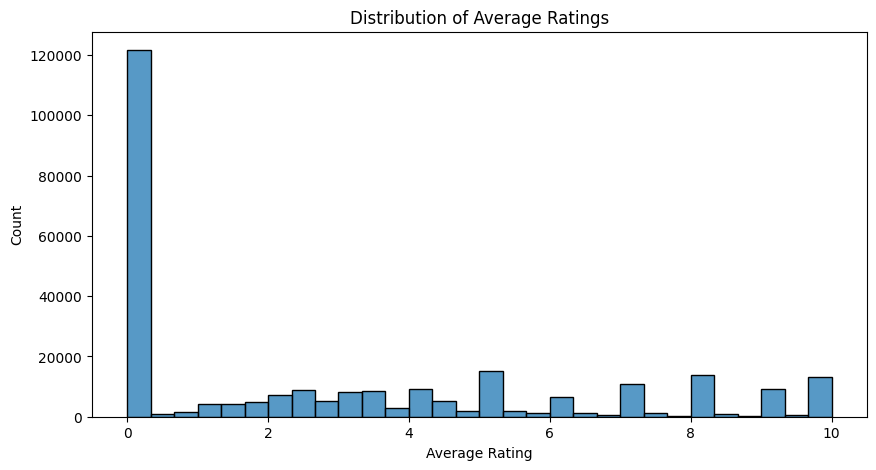

In [79]:
# Plot a histogram of average ratings
plt.figure(figsize=(10,5))
sns.histplot(books['avg_rating'], bins=30)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()


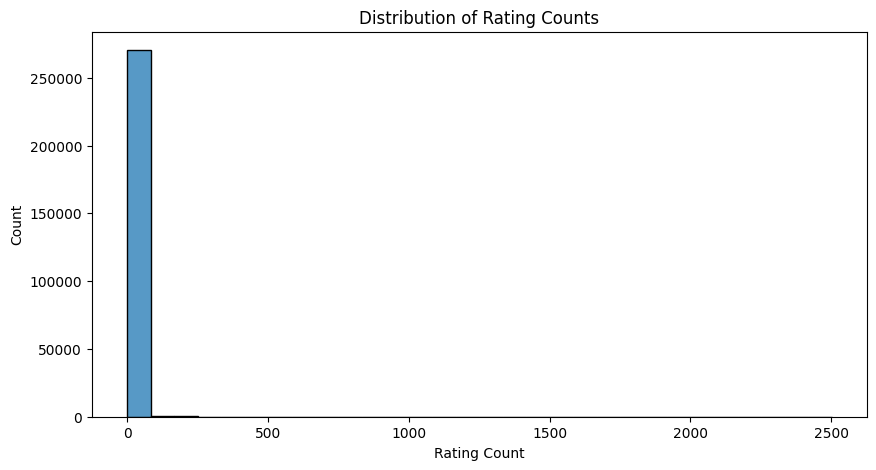

In [80]:
# Plot a histogram of rating counts
plt.figure(figsize=(10,5))
sns.histplot(books['rating_count'], bins=30)
plt.title('Distribution of Rating Counts')
plt.xlabel('Rating Count')
plt.ylabel('Count')
plt.show()


## Data preprocessing

In [81]:
# Get the ISBNs of books with more than 50 ratings
isbn_rating_count = books[books["rating_count"] > 50]["ISBN"]

# Filter the 'ratings' dataset to include only these ISBNs
filtered_ratings = ratings[ratings["ISBN"].isin(isbn_rating_count)]

# Drop duplicates
book_matrix = filtered_ratings.drop_duplicates()

# Display the new dataset
print(book_matrix)


         UserID        ISBN  Rating
0        276725  034545104X       0
2        276727  0446520802       0
8        276744  038550120X       7
10       276746  0425115801       0
11       276746  0449006522       0
...         ...         ...     ...
1149761  276704  0345386108       6
1149767  276704  0446353957       0
1149768  276704  0446605409       0
1149771  276704  0743211383       7
1149772  276704  080410526X       0

[231876 rows x 3 columns]


In [82]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import silhouette_score

# df = books[books["rating_count"] > 50]

# df['Text'] = df['Title'] + " by " + df['Author'] + 'published by' + df['Publisher']
# tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
# tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])

# silhouette_scores = []
# for k in range(1, 20):
#     kmeans = KMeans(n_clusters=k*5, random_state=42)
#     cluster_labels = kmeans.fit_predict(tfidf_matrix)
#     silhouette_scores.append(silhouette_score(tfidf_matrix, cluster_labels))

# optimal_k = 5*(silhouette_scores.index(max(silhouette_scores))+1)
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# df['Cluster'] = kmeans.fit_predict(tfidf_matrix)

# pca = PCA(n_components=2)
# tfidf_matrix_pca = pca.fit_transform(tfidf_matrix.toarray())

# plt.figure(figsize=(10, 6))
# plt.scatter(tfidf_matrix_pca[:, 0], tfidf_matrix_pca[:, 1], c=cluster_labels)
# plt.title('K-means Clustering of Books (PCA)')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.colorbar(label='Cluster')
# plt.show()

In [83]:
# from sklearn.preprocessing import StandardScaler

# # One-hot encodes all data instead of trying to use vector embeddings
# new_df = books[books["rating_count"] > 50].drop_duplicates()
# # df['Title'].value_counts()
# # df['Author'].value_counts()
# # df['Publisher'].value_counts()
# df_encoded = pd.get_dummies(new_df, columns=['Title', 'Author', 'Publisher'])
# X1 = df_encoded.drop(columns=["ISBN", 'rating_count']) # all numerical data input
# X2 = StandardScaler().fit_transform(X1) # data input as standardized
# gmm = GaussianMixture(n_components=10, random_state=777, covariance_type='diag').fit(X2)

In [84]:
# # Predict the cluster for each data point
# Y_gmm = gmm.predict(X2)

# # Visualize the clusters
# plt.figure(figsize=(10, 6))
# plt.scatter(X2[:, 0], X2[:, 1], c=Y_gmm, s=50)

# plt.title('Gaussian Mixture Model Clustering of Books (GMM)')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.colorbar(label='Cluster')
# plt.show()

In [85]:
# # Create a pivot table from book_matrix, turning the observations into 'UserID' and features into 'ISBN'
# # With 'Rating' being the values in the matrix
# book_matrix_pivot = book_matrix.pivot_table(index='UserID', columns='ISBN', values='Rating').fillna(0)

# # Turn the pivot table into a compressed matrix to make it more efficient and less demanding to run
# sparse_book_matrix = csr_matrix(book_matrix_pivot.values)

# # Print the shape of the matrices to ensure the dimensions match
# print(book_matrix_pivot.shape)
# print(sparse_book_matrix.shape)

In [86]:
# # Compute the cosine similarity matrix
# user_similarity = cosine_similarity(sparse_book_matrix)

# # Get the user IDs
# user_ids = book_matrix_pivot.index

# # Convert the cosine similarity matrix into a dataset
# user_similarity_df = pd.DataFrame(user_similarity, index=user_ids, columns=user_ids)

# # Define collaborative filtering system
# def book_recommendation(user_id, n_books):
#     # Get the similarity scores for the user
#     similarity_scores = user_similarity_df[user_id]
    
#     # Sort the scores in descending order
#     sorted_scores = similarity_scores.sort_values(ascending=False)
    
#     # Find the top n most similar users
#     top_users = sorted_scores[1:n_books+1].index
    
#     # Get the books rated by these users
#     top_books = ratings[ratings['UserID'].isin(top_users)]['ISBN'].unique()
    
#     # Exclude the books already rated by the user
#     recommended_books = [book for book in top_books if book not in ratings[ratings['UserID'] == user_id]['ISBN'].values]
    
#     return recommended_books[:n_books]

# print(book_recommendation(276704, 5))

### Collaborative Filtering Algorithms (Based on KNN, SlopeOne, Co-Clustering)
Math is in the link. To run code below, either comment out code above (for memory purposes) or delete saved variables.

In [87]:
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy


input_data = book_matrix[book_matrix['Rating'] > 0]
data = Dataset.load_from_df(input_data, Reader(rating_scale=(1,10)))

# Use the KNNBasic algorithm
model = KNNBasic()

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.3)

# Train the algorithm on the training set
model.fit(trainset)

# Make predictions on the testing set
predictions = model.test(testset)

# Evaluate the predictions using RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.8810
RMSE: 1.8810304039568984


In [88]:
from surprise import KNNWithMeans

# Use the KNNWithMeans algorithm - collaborative filtering accounting for mean ratings of each user
model= KNNWithMeans()

model.fit(trainset)

predictions = model.test(testset)

# Evaluate the predictions using RMSE
rmse_means = accuracy.rmse(predictions)
print(f"RMSE: {rmse_means}")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.8329
RMSE: 1.8329477168472343


In [89]:
# Implements SlopeOne algorithm
from surprise import SlopeOne

model = SlopeOne()
model.fit(trainset)
predictions = model.test(testset)

# Evaluate the predictions using RMSE
rmse_slope = accuracy.rmse(predictions)
print(f"RMSE: {rmse_slope}")

RMSE: 1.9230
RMSE: 1.9230053554895783


In [90]:
# Implements Co-clustering algorithm
from surprise import CoClustering

model = CoClustering()
model.fit(trainset)
predictions = model.test(testset)

# Evaluate the predictions using RMSE
rmse_cl = accuracy.rmse(predictions)
print(f"RMSE: {rmse_cl}")

# Making predictions - not implemented but can be used for all
# user_id = 'User1'
# item_id = 'ISBN1234567890'
# pred = model_slope.predict(user_id, item_id)

RMSE: 1.7419
RMSE: 1.741912074789162
